In [ ]:
import re
import math
import time
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
if "google.colab" in sys.modules:
    !pip -q install -U "transformers>=4.41.0" "datasets>=2.18.0" "sentence-transformers>=2.6.1" "accelerate>=0.30.0"
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
print("\nLoading dataset...")
ds = load_dataset("hotpot_qa", "distractor", split="validation")
print("HotpotQA validation size:", len(ds))
def normalize_text(s: str) -> str:
    s = (s or "").lower().strip()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9\s\-\']", "", s)
    return s
STOPWORDS = set("""
a an the and or but if then else when where which who whom whose what why how
is am are was were be been being do does did doing
of to in for on at by from as with about into over after before between under above
this that these those it its i you he she we they them his her our your their
""".split())

In [ ]:
@dataclass
class Passage:
    title: str
    text: str

def build_passages(example) -> List[Passage]:
    ctx = example.get("context", None)
    passages: List[Passage] = []
    if ctx is None:
        return passages
    if isinstance(ctx, dict) and "title" in ctx and ("sentences" in ctx or "sentence" in ctx):
        titles = ctx["title"]
        sents_list = ctx.get("sentences", ctx.get("sentence"))
        for title, sents in zip(titles, sents_list):
            if isinstance(sents, (list, tuple)):
                txt = " ".join([s.strip() for s in sents if isinstance(s, str) and s.strip()])
            else:
                txt = str(sents).strip()
            txt = re.sub(r"\s+", " ", txt).strip()
            if txt:
                passages.append(Passage(title=str(title), text=txt))
        return passages
    if isinstance(ctx, list) and len(ctx) > 0 and isinstance(ctx[0], dict):
        for item in ctx:
            title = item.get("title", "")
            sents = item.get("sentences", item.get("sentence", item.get("text", "")))
            if isinstance(sents, (list, tuple)):
                txt = " ".join([s.strip() for s in sents if isinstance(s, str) and s.strip()])
            else:
                txt = str(sents).strip()
            txt = re.sub(r"\s+", " ", txt).strip()
            if txt:
                passages.append(Passage(title=str(title), text=txt))
        return passages
    if isinstance(ctx, list):
        for item in ctx:
            if isinstance(item, (list, tuple)) and len(item) >= 2:
                title = item[0]
                sents = item[1]
                if isinstance(sents, (list, tuple)):
                    txt = " ".join([s.strip() for s in sents if isinstance(s, str) and s.strip()])
                else:
                    txt = str(sents).strip()
                txt = re.sub(r"\s+", " ", txt).strip()
                if txt:
                    passages.append(Passage(title=str(title), text=txt))
    return passages

print("\nLoading embedder...")
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

@torch.no_grad()
def retrieve_topk(question: str, passages: List[Passage], k: int = 4) -> Tuple[List[int], np.ndarray]:
    if len(passages) == 0:
        return [], np.array([])
    p_texts = [f"{p.title}: {p.text}" for p in passages]
    q_emb = embedder.encode([question], normalize_embeddings=True)
    p_emb = embedder.encode(p_texts, normalize_embeddings=True)
    sims = (p_emb @ q_emb.T).squeeze(-1)
    top_idx = np.argsort(-sims)[: min(k, len(passages))]
    return top_idx.tolist(), sims

def make_prompt(question: str, retrieved: List[Passage]) -> str:
    blocks = []
    for i, p in enumerate(retrieved, 1):
        blocks.append(f"[Evidence {i}] {p.title}: {p.text}")
    ctx = "\n".join(blocks) if blocks else "(no evidence retrieved)"
    prompt = (
        "Answer the question using ONLY the evidence below. "
        "If the evidence is insufficient, say 'Insufficient evidence'.\n\n"
        f"{ctx}\n\n"
        f"Question: {question}\n"
        "Answer:"
    )
    return prompt

In [ ]:
print("\nLoading generator model...")
GEN_MODEL = "google/flan-t5-base"
tok = AutoTokenizer.from_pretrained(GEN_MODEL)
gen = AutoModelForSeq2SeqLM.from_pretrained(GEN_MODEL).to(device)
gen.eval()

@torch.no_grad()
def generate_answer(prompt: str, max_new_tokens: int = 32) -> Tuple[str, Dict[str, float]]:
    inputs = tok(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
    out = gen.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        num_beams=4,
        early_stopping=True,
        return_dict_in_generate=True,
        output_scores=True
    )
    text = tok.decode(out.sequences[0], skip_special_tokens=True).strip()
    confs = []
    for step_logits in out.scores:
        probs = torch.softmax(step_logits[0], dim=-1)
        confs.append(float(torch.max(probs).detach().cpu()))
    avg_step_conf = float(np.mean(confs)) if confs else float("nan")
    return text, {"avg_step_conf": avg_step_conf}

def answer_supported_by_evidence(answer: str, retrieved: List[Passage]) -> bool:
    a = normalize_text(answer)
    if a in ["insufficient evidence", "insufficient", "not enough evidence"]:
        return True
    if len(a) < 3 or len(retrieved) == 0:
        return False
    evidence_blob = " ".join([normalize_text(p.text) for p in retrieved])
    return a in evidence_blob

In [ ]:
def integrated_gradients_input_attrib(
    prompt: str,
    target_text: str,
    steps: int = 16,
    max_src_len: int = 512,
    max_tgt_len: int = 64,
) -> Dict:
    gen.eval()
    src = tok(prompt, return_tensors="pt", truncation=True, max_length=max_src_len)
    tgt = tok(target_text, return_tensors="pt", truncation=True, max_length=max_tgt_len)
    input_ids = src["input_ids"].to(device)
    attn_mask = src["attention_mask"].to(device)
    labels = tgt["input_ids"].to(device)
    pad_id = tok.pad_token_id
    baseline_ids = torch.full_like(input_ids, pad_id)
    emb_layer = gen.get_input_embeddings()
    x_emb = emb_layer(input_ids)
    b_emb = emb_layer(baseline_ids)
    delta = x_emb - b_emb
    total_grads = torch.zeros_like(x_emb)
    for s in range(1, steps + 1):
        alpha = float(s) / float(steps)
        interp = (b_emb + alpha * delta).detach().clone().requires_grad_(True)
        outputs = gen(
            inputs_embeds=interp,
            attention_mask=attn_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        total_grads += interp.grad.detach()
        gen.zero_grad(set_to_none=True)
    avg_grads = total_grads / steps
    ig = (delta * avg_grads).detach()
    token_attr = ig.abs().sum(dim=-1).squeeze(0)
    tokens = tok.convert_ids_to_tokens(input_ids.squeeze(0).tolist())
    return {
        "tokens": tokens,
        "token_attr": token_attr.detach().cpu().numpy(),
        "prompt": prompt,
        "target_text": target_text
    }

def topk_attr_tokens(tokens: List[str], attrs: np.ndarray, k: int = 20) -> List[Tuple[str, float]]:
    pairs = []
    for t, a in zip(tokens, attrs):
        if t in [tok.pad_token, tok.eos_token] or t is None:
            continue
        pairs.append((t, float(a)))
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs[:k]

def attribution_evidence_overlap(
    ig_out: Dict,
    retrieved: List[Passage],
    top_k: int = 20
) -> Dict[str, float]:
    top = topk_attr_tokens(ig_out["tokens"], ig_out["token_attr"], k=top_k)
    top_words = []
    for t, _a in top:
        w = t.replace("▁", "").strip()
        if not w:
            continue
        w_norm = normalize_text(w)
        if not w_norm or w_norm in STOPWORDS:
            continue
        top_words.append(w_norm)
    evidence_blob = normalize_text(" ".join([p.text for p in retrieved]))
    if len(top_words) == 0 or len(evidence_blob) == 0:
        return {"attr_overlap": 0.0}
    hits = sum([1 for w in top_words if w in evidence_blob])
    return {"attr_overlap": hits / len(top_words)}

Device: cpu

Loading dataset...
HotpotQA validation size: 7405

Loading embedder...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Loading generator model...


Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning



Selected 24 examples.
Done 4/24
Done 8/24
Done 12/24
Done 16/24
Done 20/24
Done 24/24

Batch done in 659.1s

=== Summary ===
Supported by retrieved evidence: 87.5%
Unsupported but high-conf flag: 12.5%
Stubborn hallucination flag: 4.2%
Avg confidence: 0.902
Avg attribution overlap (top-20 tokens): 0.380 (IG subset)

=== Sample Rows ===
------------------------------------------------------------------------------------------
Q: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
A: Insufficient evidence
Supported: True | Conf: 0.967 | SameAfterRemoval: True
AttrOverlapTop20: 0.133
TopAttrTokens: sufficient:4.49, sufficient:2.99, ▁evidence:2.87, In:2.76, ▁Answer:2.67, ▁evidence:2.44, ▁say:2.26, ':2.25
Flags: - -
------------------------------------------------------------------------------------------
Q: When did the park at which Tivolis Koncertsal is located open?
A: 15 August 1843
Supported: True | Con

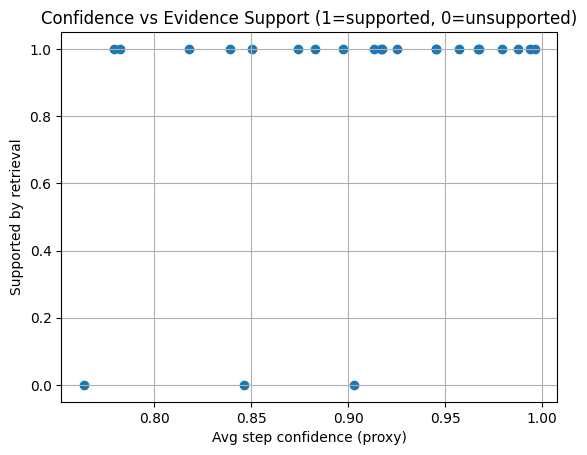

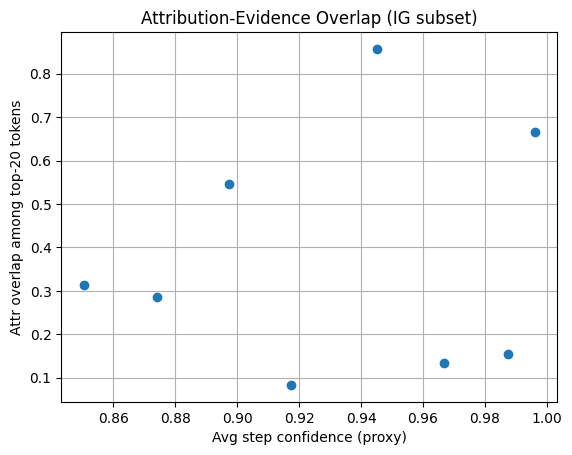


=== Deep Dive Example ===
Question: What was Iqbal F. Qadir on when he participated in an attack on a radar station located on western shore of the Okhamandal Peninsula?
Answer: Insufficient evidence
Supported: True
Retrieved evidence titles: ['Iqbal F. Qadir', 'Mukachevo Radar Station', 'Sevastopol Radar Station', 'Radar Station B-71']

Top attributed prompt tokens:
  sufficient  4.4925
  sufficient  2.9935
   ▁evidence  2.8654
          In  2.7582
     ▁Answer  2.6726
   ▁evidence  2.4386
        ▁say  2.2601
           '  2.2462
   ▁evidence  2.1071
      ▁below  1.9848
   ▁question  1.8353
       ▁ONLY  1.8060
      ▁using  1.6367
         ▁If  1.5180
          ▁[  1.4692
  ▁generator  1.4403
           '  1.2732
           ,  1.2081
           ▁  1.0406
     ▁diesel  0.9927


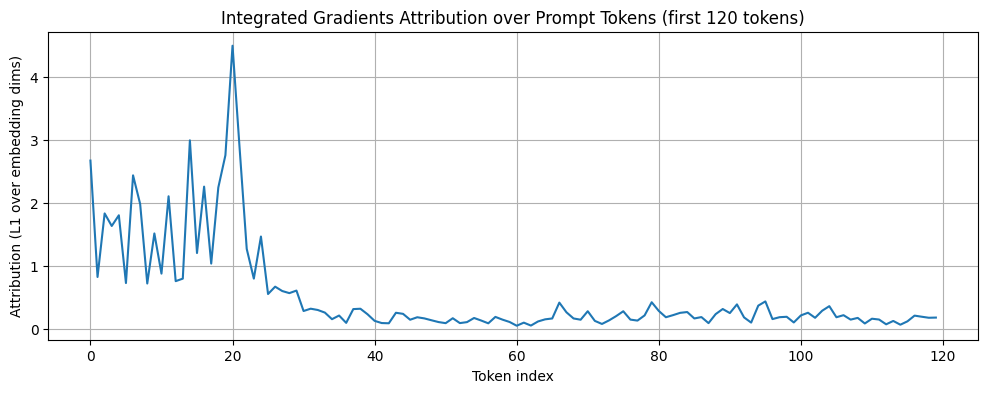


Prompt snippet (brackets mark top-attribution tokens):
[ Answer] the[ question] using[ ONLY] the[ evidence][ below]. If the[ evidence] is in[sufficient],[ say] ['][In][sufficient][ evidence][']. [Evidence 1] Iqbal F. Qadir: Vice-Admiral Iqbal Fazl Quadir (Urdu:<unk> <unk> <unk>) , is a retired three-star rank admiral in the Pakistan Navy, former diplomat, and a defence analyst. He is renown for his participation in second war with India when he was part of the flotilla that attacked the radar station

Done.


In [2]:
def evidence_removal_test(question: str, passages: List[Passage], k: int = 4) -> Dict:
    top_idx, _sims = retrieve_topk(question, passages, k=k)
    retrieved = [passages[i] for i in top_idx] if top_idx else []
    prompt_full = make_prompt(question, retrieved)
    ans_full, conf_full = generate_answer(prompt_full)
    retrieved_removed = retrieved[1:] if len(retrieved) > 1 else []
    prompt_removed = make_prompt(question, retrieved_removed) if len(retrieved_removed) > 0 else (
        "Answer the question. If you do not know, say 'Insufficient evidence'.\n\n"
        f"Question: {question}\nAnswer:"
    )
    ans_removed, conf_removed = generate_answer(prompt_removed)
    same = normalize_text(ans_full) == normalize_text(ans_removed)
    return {
        "ans_full": ans_full,
        "ans_removed": ans_removed,
        "same_after_removal": bool(same),
        "conf_full": conf_full["avg_step_conf"],
        "conf_removed": conf_removed["avg_step_conf"],
        "retrieved": retrieved
    }

N_EXAMPLES = 24
N_IG = 8
TOPK = 4

def pick_examples(dataset, n: int) -> List[Dict]:
    idxs = list(range(len(dataset)))
    random.shuffle(idxs)
    chosen = []
    for i in idxs:
        ex = dataset[i]
        q = ex.get("question", "")
        if isinstance(q, str) and 0 < len(q) < 180:
            chosen.append(ex)
        if len(chosen) >= n:
            break
    return chosen

examples = pick_examples(ds, N_EXAMPLES)
print(f"\nSelected {len(examples)} examples.")
results = []
t_start = time.time()

for j, ex in enumerate(examples):
    question = ex.get("question", "")
    gold = ex.get("answer", "")
    passages = build_passages(ex)
    test = evidence_removal_test(question, passages, k=TOPK)
    retrieved = test["retrieved"]
    ans = test["ans_full"]
    supported = answer_supported_by_evidence(ans, retrieved)
    row = {
        "i": j,
        "question": question,
        "gold": gold,
        "answer": ans,
        "supported_by_retrieval": supported,
        "same_after_removal": test["same_after_removal"],
        "conf_full": test["conf_full"],
        "conf_removed": test["conf_removed"],
    }
    if j < N_IG:
        try:
            ig_steps = 16 if device == "cuda" else 8
            ig = integrated_gradients_input_attrib(
                prompt=make_prompt(question, retrieved),
                target_text=ans,
                steps=ig_steps
            )
            overlap = attribution_evidence_overlap(ig, retrieved, top_k=20)
            row["attr_overlap_top20"] = overlap["attr_overlap"]
            top_tokens = topk_attr_tokens(ig["tokens"], ig["token_attr"], k=12)
            row["top_attr_tokens"] = ", ".join([f"{t}:{a:.2f}" for t, a in top_tokens[:8]])
        except Exception as e:
            row["attr_overlap_top20"] = float("nan")
            row["top_attr_tokens"] = f"IG failed: {type(e).__name__}"
    else:
        row["attr_overlap_top20"] = float("nan")
        row["top_attr_tokens"] = ""
    row["hallucination_flag_unsupported_highconf"] = (not supported) and (row["conf_full"] >= 0.55)
    row["hallucination_flag_stubborn"] = (not supported) and row["same_after_removal"]
    results.append(row)
    if (j + 1) % 4 == 0:
        print(f"Done {j+1}/{len(examples)}")

elapsed = time.time() - t_start
print(f"\nBatch done in {elapsed:.1f}s")

def safe_mean(xs):
    xs2 = [x for x in xs if isinstance(x, (int, float)) and not (isinstance(x, float) and math.isnan(x))]
    return float(np.mean(xs2)) if xs2 else float("nan")

supported_rate = sum(r["supported_by_retrieval"] for r in results) / len(results)
stubborn_rate = sum(r["hallucination_flag_stubborn"] for r in results) / len(results)
uh_rate = sum(r["hallucination_flag_unsupported_highconf"] for r in results) / len(results)
avg_conf = safe_mean([r["conf_full"] for r in results])
avg_attr_overlap = safe_mean([r["attr_overlap_top20"] for r in results])

print("\n=== Summary ===")
print("Supported by retrieved evidence:", f"{supported_rate*100:.1f}%")
print("Unsupported but high-conf flag:", f"{uh_rate*100:.1f}%")
print("Stubborn hallucination flag:", f"{stubborn_rate*100:.1f}%")
print("Avg confidence:", f"{avg_conf:.3f}")
print("Avg attribution overlap (top-20 tokens):", f"{avg_attr_overlap:.3f} (IG subset)")

confs = np.array([r["conf_full"] for r in results], dtype=float)
supported_arr = np.array([1.0 if r["supported_by_retrieval"] else 0.0 for r in results], dtype=float)
ig_overlap = np.array([r["attr_overlap_top20"] for r in results], dtype=float)

plt.figure()
plt.title("Confidence vs Evidence Support (1=supported, 0=unsupported)")
plt.scatter(confs, supported_arr)
plt.xlabel("Avg step confidence (proxy)")
plt.ylabel("Supported by retrieval")
plt.grid(True)
plt.show()